In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import random
from generate_data import generate_Ls, generate_sylvester_data
from proximal_gradient_descent import (
    get_optimizer_oracles,
    proximal_accelerated_gradient,
    project_to_lower_with_positive_diag,
    warm_start
)
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score
from plotting_utilities import get_metrics, patternify_Ls, one_example_prs
import scanpy as sc
import igraph as ig
import xarray as xr

import os

# Prevent Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Load data

In [64]:
# Load data
# Get all types of objects
data_dir = 'data/coil-20-proc/'
headers = {x.split('__')[0] for x in os.listdir(data_dir)}
print(headers)

{'obj9', 'obj18', 'obj20', 'obj14', 'obj19', 'obj16', 'obj10', 'obj17', '.DS_Store', 'obj15', 'obj3', 'obj13', 'obj5', 'obj8', 'obj6', 'obj7', 'obj11', 'obj1', 'obj4', 'obj12', 'obj2'}


We'll only use obj1, the duck.

In [65]:
# This video has 72 frames, with 128x128 pixels

# Get all images of the object
images = [x for x in os.listdir(data_dir) if x.split('__')[0] == 'obj1']
frame_numbers = [int(x.split('__')[1].split('.')[0]) for x in images]
data = np.ndarray((len(images), 128, 128))
for i, image in zip(frame_numbers, images):
    data[i] = plt.imread(data_dir + image)

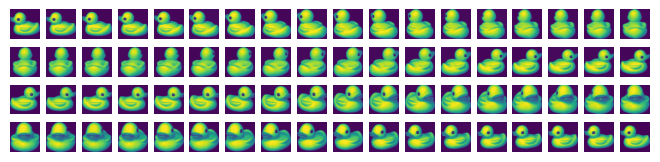

In [66]:
fig, axs = plt.subplots(ncols=18, nrows=4)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data[i])
    ax.axis('off')
# lower remove margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.7)

The frames are 'circular', so we'll drop the last half to make the true graph a DAG.  We'll also downsample to every other frame, and every fourth pixel, to increase runtime.

In [169]:
duck = data[:data.shape[0]//2:2, ::4, ::4].copy()
duck -= duck.mean()
duck /= (duck**2).sum()
duck.shape

(18, 32, 32)

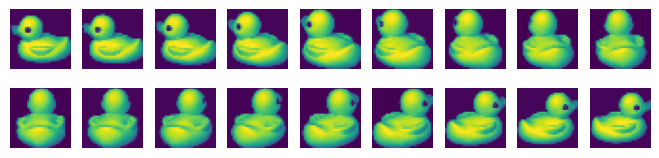

In [170]:
fig, axs = plt.subplots(ncols=9, nrows=2)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(duck[i])
    ax.axis('off')
# lower remove margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.7)

In [171]:
dims = duck.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = [9.1e-3, 5e-3, 5e-3]
objective, gradient, proximal = get_optimizer_oracles(duck, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

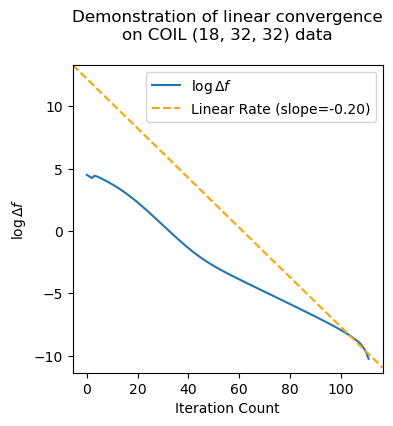

In [172]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))

# Ignore iterations where the objective error increased
# (we use accelerated gradient descent so this will happen every now
# and then, which is annoying for taking the logarithm)
iterations = iterations[del_f > 0]
del_f = np.log10(del_f[del_f > 0])

# Fit a line through the data to demonstrate it really is linear
try:
    linear_data = iterations > 100
    slope, intercept = np.polyfit(iterations[linear_data], del_f[linear_data], deg=1)
except:
    slope = None

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of linear convergence\non COIL {dims} data\n")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
if slope is not None:
    ax.axline(xy1=(0, intercept), slope=slope, linestyle='--', color='orange', label=f'Linear Rate ({slope=:.2f})')
ax.legend()
pass

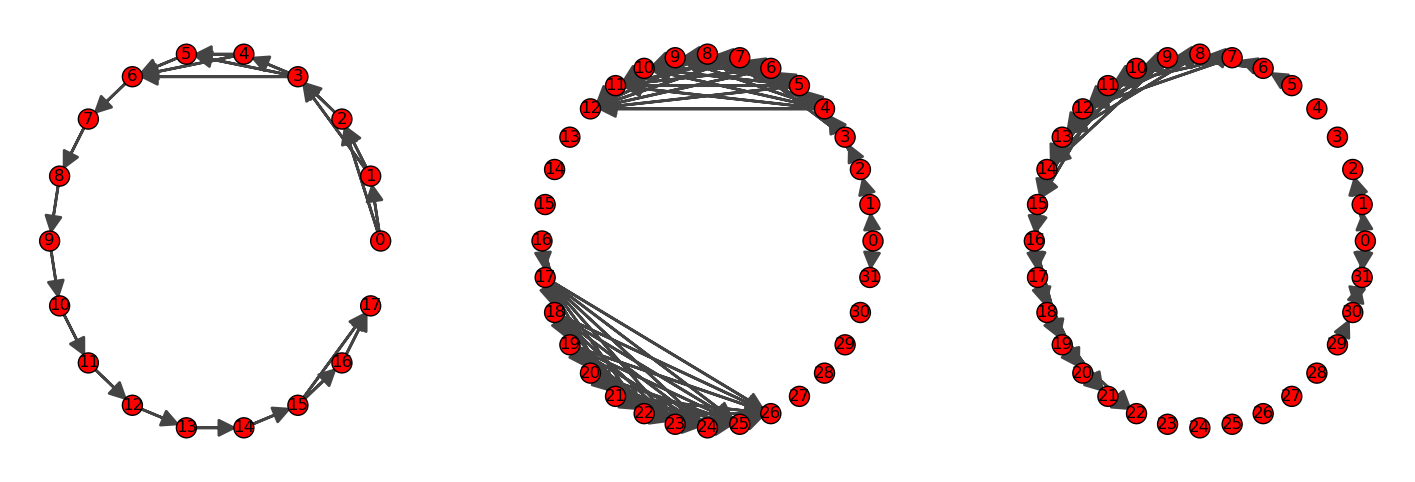

In [178]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=3)

for L, ax in zip(Ls, axs):
    graph = ig.Graph.Weighted_Adjacency(L.T - np.diag(np.diag(L)))
    graph.vs['label'] = np.arange(L.shape[0])

    ig.plot(
        graph,
        target=ax,
        layout='circle',
        vertex_size=20
    )

In [187]:
duck = data[:data.shape[0]//2:2, ::8, ::8].copy()
duck -= duck.mean()
duck /= (duck**2).sum()
duck.shape

(18, 16, 16)

In [ ]:
dims = duck.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

frame_range = np.logspace(-1.5, -3, 10)
row_range = np.logspace(-2, -4, 10)
col_range = np.logspace(-2, -4, 10)

glassoregs = [
    (f, r, c)
    for f in frame_range
    for r in row_range
    for c in col_range
]

Lss, diagnostics = warm_start(
    duck.copy(),
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True,
    dont_warm_start=True # numerical stability is causing problems...
)

L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.005994842503189409))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.003593813663804626))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.0021544346900318843))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.001291549665014884))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.000774263682681127))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.0004641588833612782))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.0002782559402207126))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.0001668100537200059))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.01), np.float64(0.0001))
L1 Param: (np.float64(0.03162277660168379), np.float64(0.005994842

In [192]:
true_frames = (np.triu(np.tril(np.ones((18, 18)), k=-1), k=-1) != 0).reshape(-1)

In [193]:
mccs = []

for Ls in Lss:
    frames = (Ls[0] - np.diag(np.diag(Ls[0]))).reshape(-1) != 0
    mccs.append(matthews_corrcoef(true_frames, frames))

print(max(mccs))

0.49871473964781354


In [217]:
print(np.argmax(np.array(mccs)))
mask = np.array(mccs) == max(mccs)
print(len([g for i, g in enumerate(glassoregs) if mask[i]]))
print(glassoregs[200])

200
100
(np.float64(0.014677992676220698), np.float64(0.01), np.float64(0.01))


In [219]:
dims = duck.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = glassoregs[200]
objective, gradient, proximal = get_optimizer_oracles(duck, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

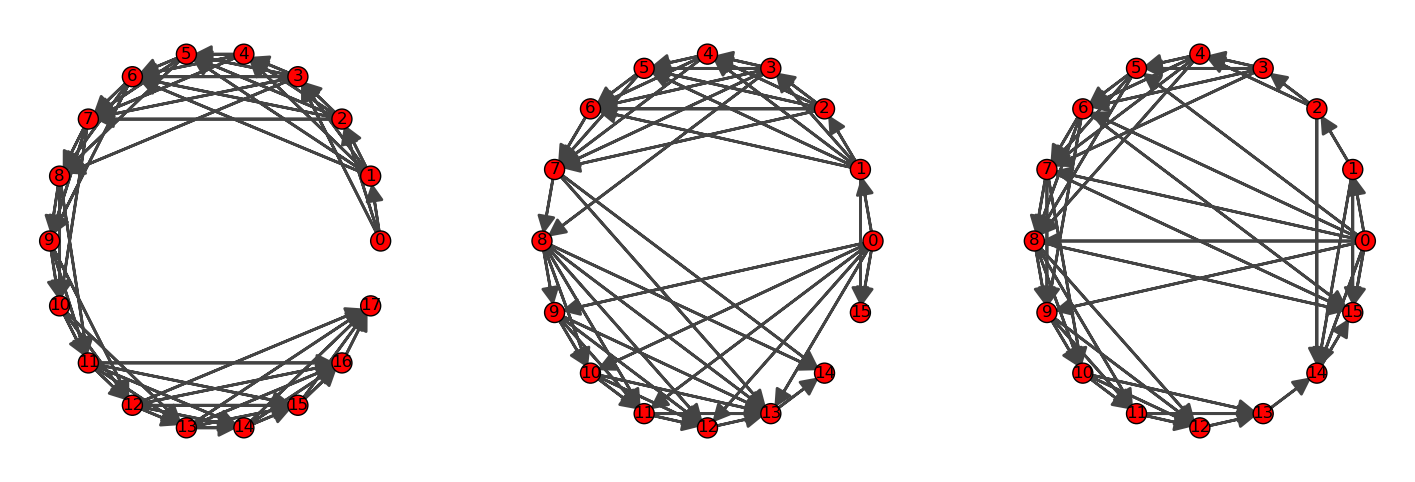

In [220]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=3)

for L, ax in zip(Ls, axs):
    graph = ig.Graph.Weighted_Adjacency(L.T - np.diag(np.diag(L)))
    graph.vs['label'] = np.arange(L.shape[0])

    ig.plot(
        graph,
        target=ax,
        layout='circle',
        vertex_size=20
    )

In [221]:
dims = duck.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

frame_range = np.logspace(-1, -4, 100)
row_range = np.logspace(-2, -2, 1)
col_range = np.logspace(-2, -2, 1)

glassoregs2 = [
    (f, r, c)
    for f in frame_range
    for r in row_range
    for c in col_range
]

Lss2, diagnostics = warm_start(
    duck.copy(),
    L_init=L_init,
    glassoregs = glassoregs2,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True,
    dont_warm_start=True # numerical stability is causing problems...
)

L1 Param: (np.float64(0.1), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.093260334688322), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.08697490026177834), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.08111308307896872), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.07564633275546291), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.07054802310718641), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.0657933224657568), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.06135907273413173), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.05722367659350217), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.0533669923120631), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.049770235643321115), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.046415888336127774), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.04328761281083057), np.float64(0.0

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: (np.float64(0.006135907273413176), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.00572236765935022), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.005336699231206312), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.004977023564332114), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.004641588833612777), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.004328761281083057), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.004037017258596553), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.0037649358067924675), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.003511191734215131), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.0032745491628777285), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.0030538555088334154), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.002848035868435802), np.float64(0.01), np.float64(0.01))
L1 Param: (np.float64(0.00

In [226]:
mccs = []

for Ls in Lss2:
    frames = (Ls[0] - np.diag(np.diag(Ls[0]))).reshape(-1) != 0
    mccs.append(matthews_corrcoef(true_frames, frames))

print(max(mccs))
print(np.argmax(mccs))
print(glassoregs2[np.argmax(mccs)])

0.8138059537095804
25
(np.float64(0.01747528400007684), np.float64(0.01), np.float64(0.01))


In [227]:
dims = duck.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.01747528400007684
objective, gradient, proximal = get_optimizer_oracles(duck, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

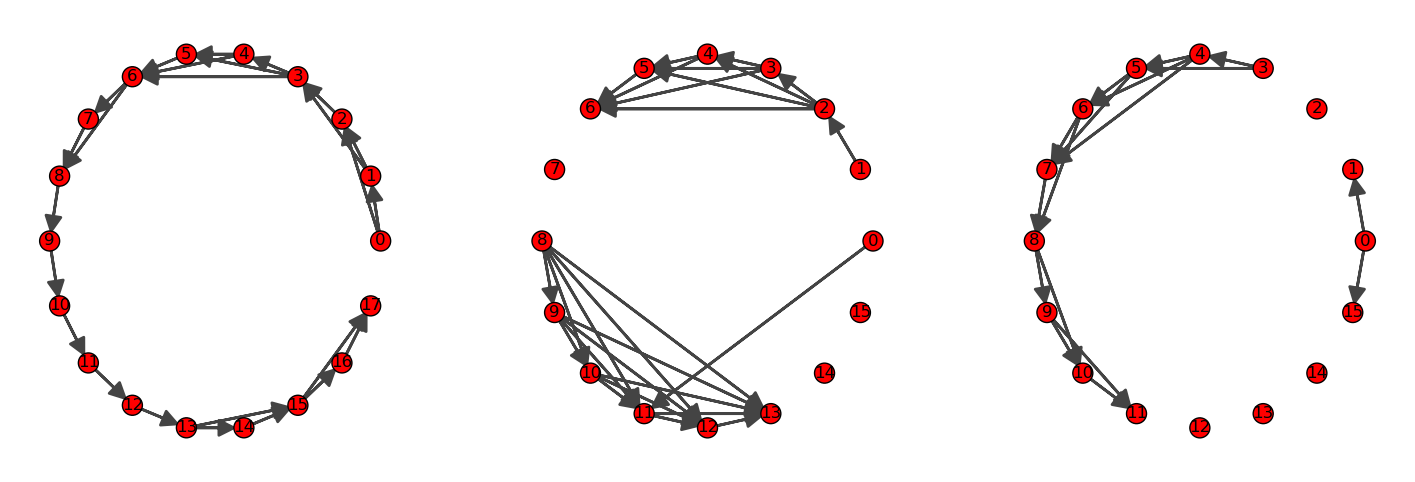

In [228]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=3)

for L, ax in zip(Ls, axs):
    graph = ig.Graph.Weighted_Adjacency(L.T - np.diag(np.diag(L)))
    graph.vs['label'] = np.arange(L.shape[0])

    ig.plot(
        graph,
        target=ax,
        layout='circle',
        vertex_size=20
    )

In [239]:
dims = duck.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

frame_range = np.logspace(-1.6, -2, 100)

glassoregs3 = [(f, f, f) for f in frame_range]

Lss3, diagnostics = warm_start(
    duck.copy(),
    L_init=L_init,
    glassoregs = glassoregs3,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True,
    dont_warm_start=True # numerical stability is causing problems...
)

L1 Param: (np.float64(0.025118864315095794), np.float64(0.025118864315095794), np.float64(0.025118864315095794))
L1 Param: (np.float64(0.024886257813454698), np.float64(0.024886257813454698), np.float64(0.024886257813454698))
L1 Param: (np.float64(0.024655805301895595), np.float64(0.024655805301895595), np.float64(0.024655805301895595))
L1 Param: (np.float64(0.024427486833971414), np.float64(0.024427486833971414), np.float64(0.024427486833971414))
L1 Param: (np.float64(0.02420128264794381), np.float64(0.02420128264794381), np.float64(0.02420128264794381))
L1 Param: (np.float64(0.023977173165072713), np.float64(0.023977173165072713), np.float64(0.023977173165072713))
L1 Param: (np.float64(0.023755138987921694), np.float64(0.023755138987921694), np.float64(0.023755138987921694))
L1 Param: (np.float64(0.02353516089867911), np.float64(0.02353516089867911), np.float64(0.02353516089867911))
L1 Param: (np.float64(0.02331721985749469), np.float64(0.02331721985749469), np.float64(0.023317219857

In [240]:
mccs = []

for Ls in Lss3:
    frames = (Ls[0] - np.diag(np.diag(Ls[0]))).reshape(-1) != 0
    mccs.append(matthews_corrcoef(true_frames, frames))

print(max(mccs))
print(np.argmax(mccs))
print(glassoregs3[np.argmax(mccs)])

0.8319750058886701
37
(np.float64(0.017803486127948385), np.float64(0.017803486127948385), np.float64(0.017803486127948385))


In [241]:
dims = duck.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = glassoregs3[np.argmax(mccs)]
objective, gradient, proximal = get_optimizer_oracles(duck, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

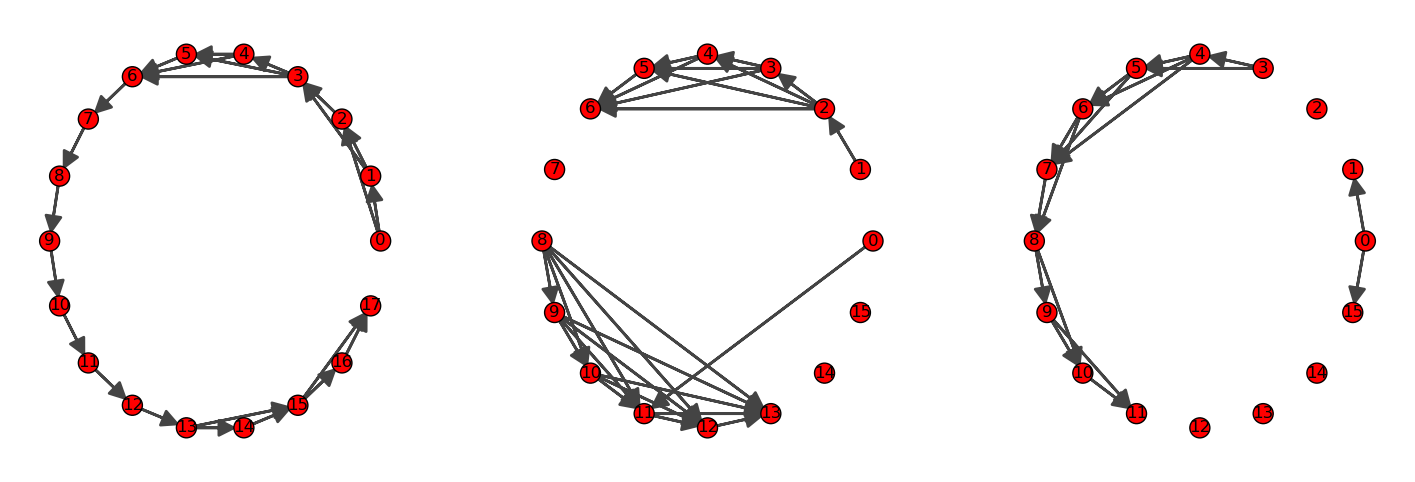

In [242]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=3)

for L, ax in zip(Ls, axs):
    graph = ig.Graph.Weighted_Adjacency(L.T - np.diag(np.diag(L)))
    graph.vs['label'] = np.arange(L.shape[0])

    ig.plot(
        graph,
        target=ax,
        layout='circle',
        vertex_size=20
    )

In [278]:
dims = duck.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

frame_range = np.logspace(-1.6, -2.4, 100)

glassoregs4 = [(f, f, f) for f in frame_range]

Lss4, diagnostics = warm_start(
    duck.copy(),
    L_init=L_init,
    glassoregs = glassoregs4,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True,
    dont_warm_start=True, # numerical stability is causing problems...
    sample_axes={1, 2}
)

L1 Param: (np.float64(0.025118864315095794), np.float64(0.025118864315095794), np.float64(0.025118864315095794))
L1 Param: (np.float64(0.024655805301895595), np.float64(0.024655805301895595), np.float64(0.024655805301895595))
L1 Param: (np.float64(0.02420128264794381), np.float64(0.02420128264794381), np.float64(0.02420128264794381))
L1 Param: (np.float64(0.023755138987921694), np.float64(0.023755138987921694), np.float64(0.023755138987921694))
L1 Param: (np.float64(0.02331721985749469), np.float64(0.02331721985749469), np.float64(0.02331721985749469))
L1 Param: (np.float64(0.022887373639833695), np.float64(0.022887373639833695), np.float64(0.022887373639833695))
L1 Param: (np.float64(0.02246545151312208), np.float64(0.02246545151312208), np.float64(0.02246545151312208))
L1 Param: (np.float64(0.022051307399030457), np.float64(0.022051307399030457), np.float64(0.022051307399030457))
L1 Param: (np.float64(0.02164479791214124), np.float64(0.02164479791214124), np.float64(0.021644797912141

In [279]:
mccs = []

for Ls in Lss4:
    frames = (Ls[0] - np.diag(np.diag(Ls[0]))).reshape(-1) != 0
    mccs.append(matthews_corrcoef(true_frames, frames))

print(max(mccs))
print(np.argmax(mccs))
print(glassoregs4[np.argmax(mccs)])

0.8319750058886701
49
(np.float64(0.010093467850162406), np.float64(0.010093467850162406), np.float64(0.010093467850162406))


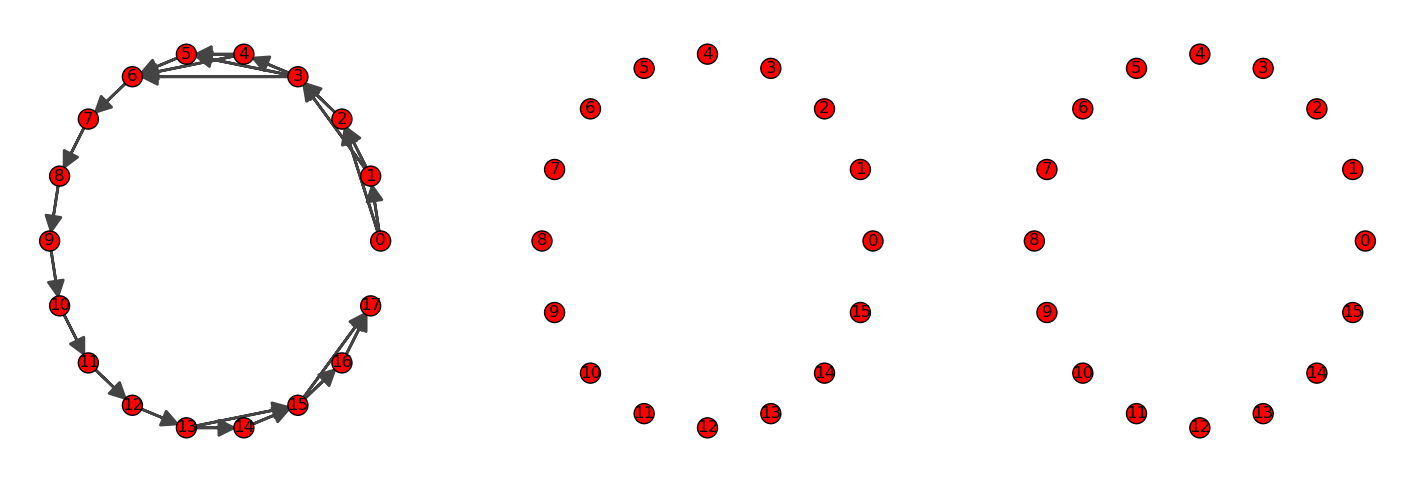

In [280]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=3)

for L, ax in zip(Lss4[np.argmax(mccs)], axs):
    graph = ig.Graph.Weighted_Adjacency(L.T - np.diag(np.diag(L)))
    graph.vs['label'] = np.arange(L.shape[0])

    ig.plot(
        graph,
        target=ax,
        layout='circle',
        vertex_size=20
    )